# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 7: Multiclass Classification

**Harvard University**<br/>
**Fall 2018**<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader <br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib 
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix

from scipy import linalg
from scipy.stats import multivariate_normal
import itertools
import time
from itertools import combinations
from IPython.display import Image

from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set(style='white')

### This data is from the [Sloan Digital Sky Server](http://cas.sdss.org/dr14/en/sdss/sdsshome.aspx)

#### The Sloan Digital Sky Survey is a project to make a map of a large part of the universe using a 2.5 meters telescope located at Apache Point Observatory in New Mexico.

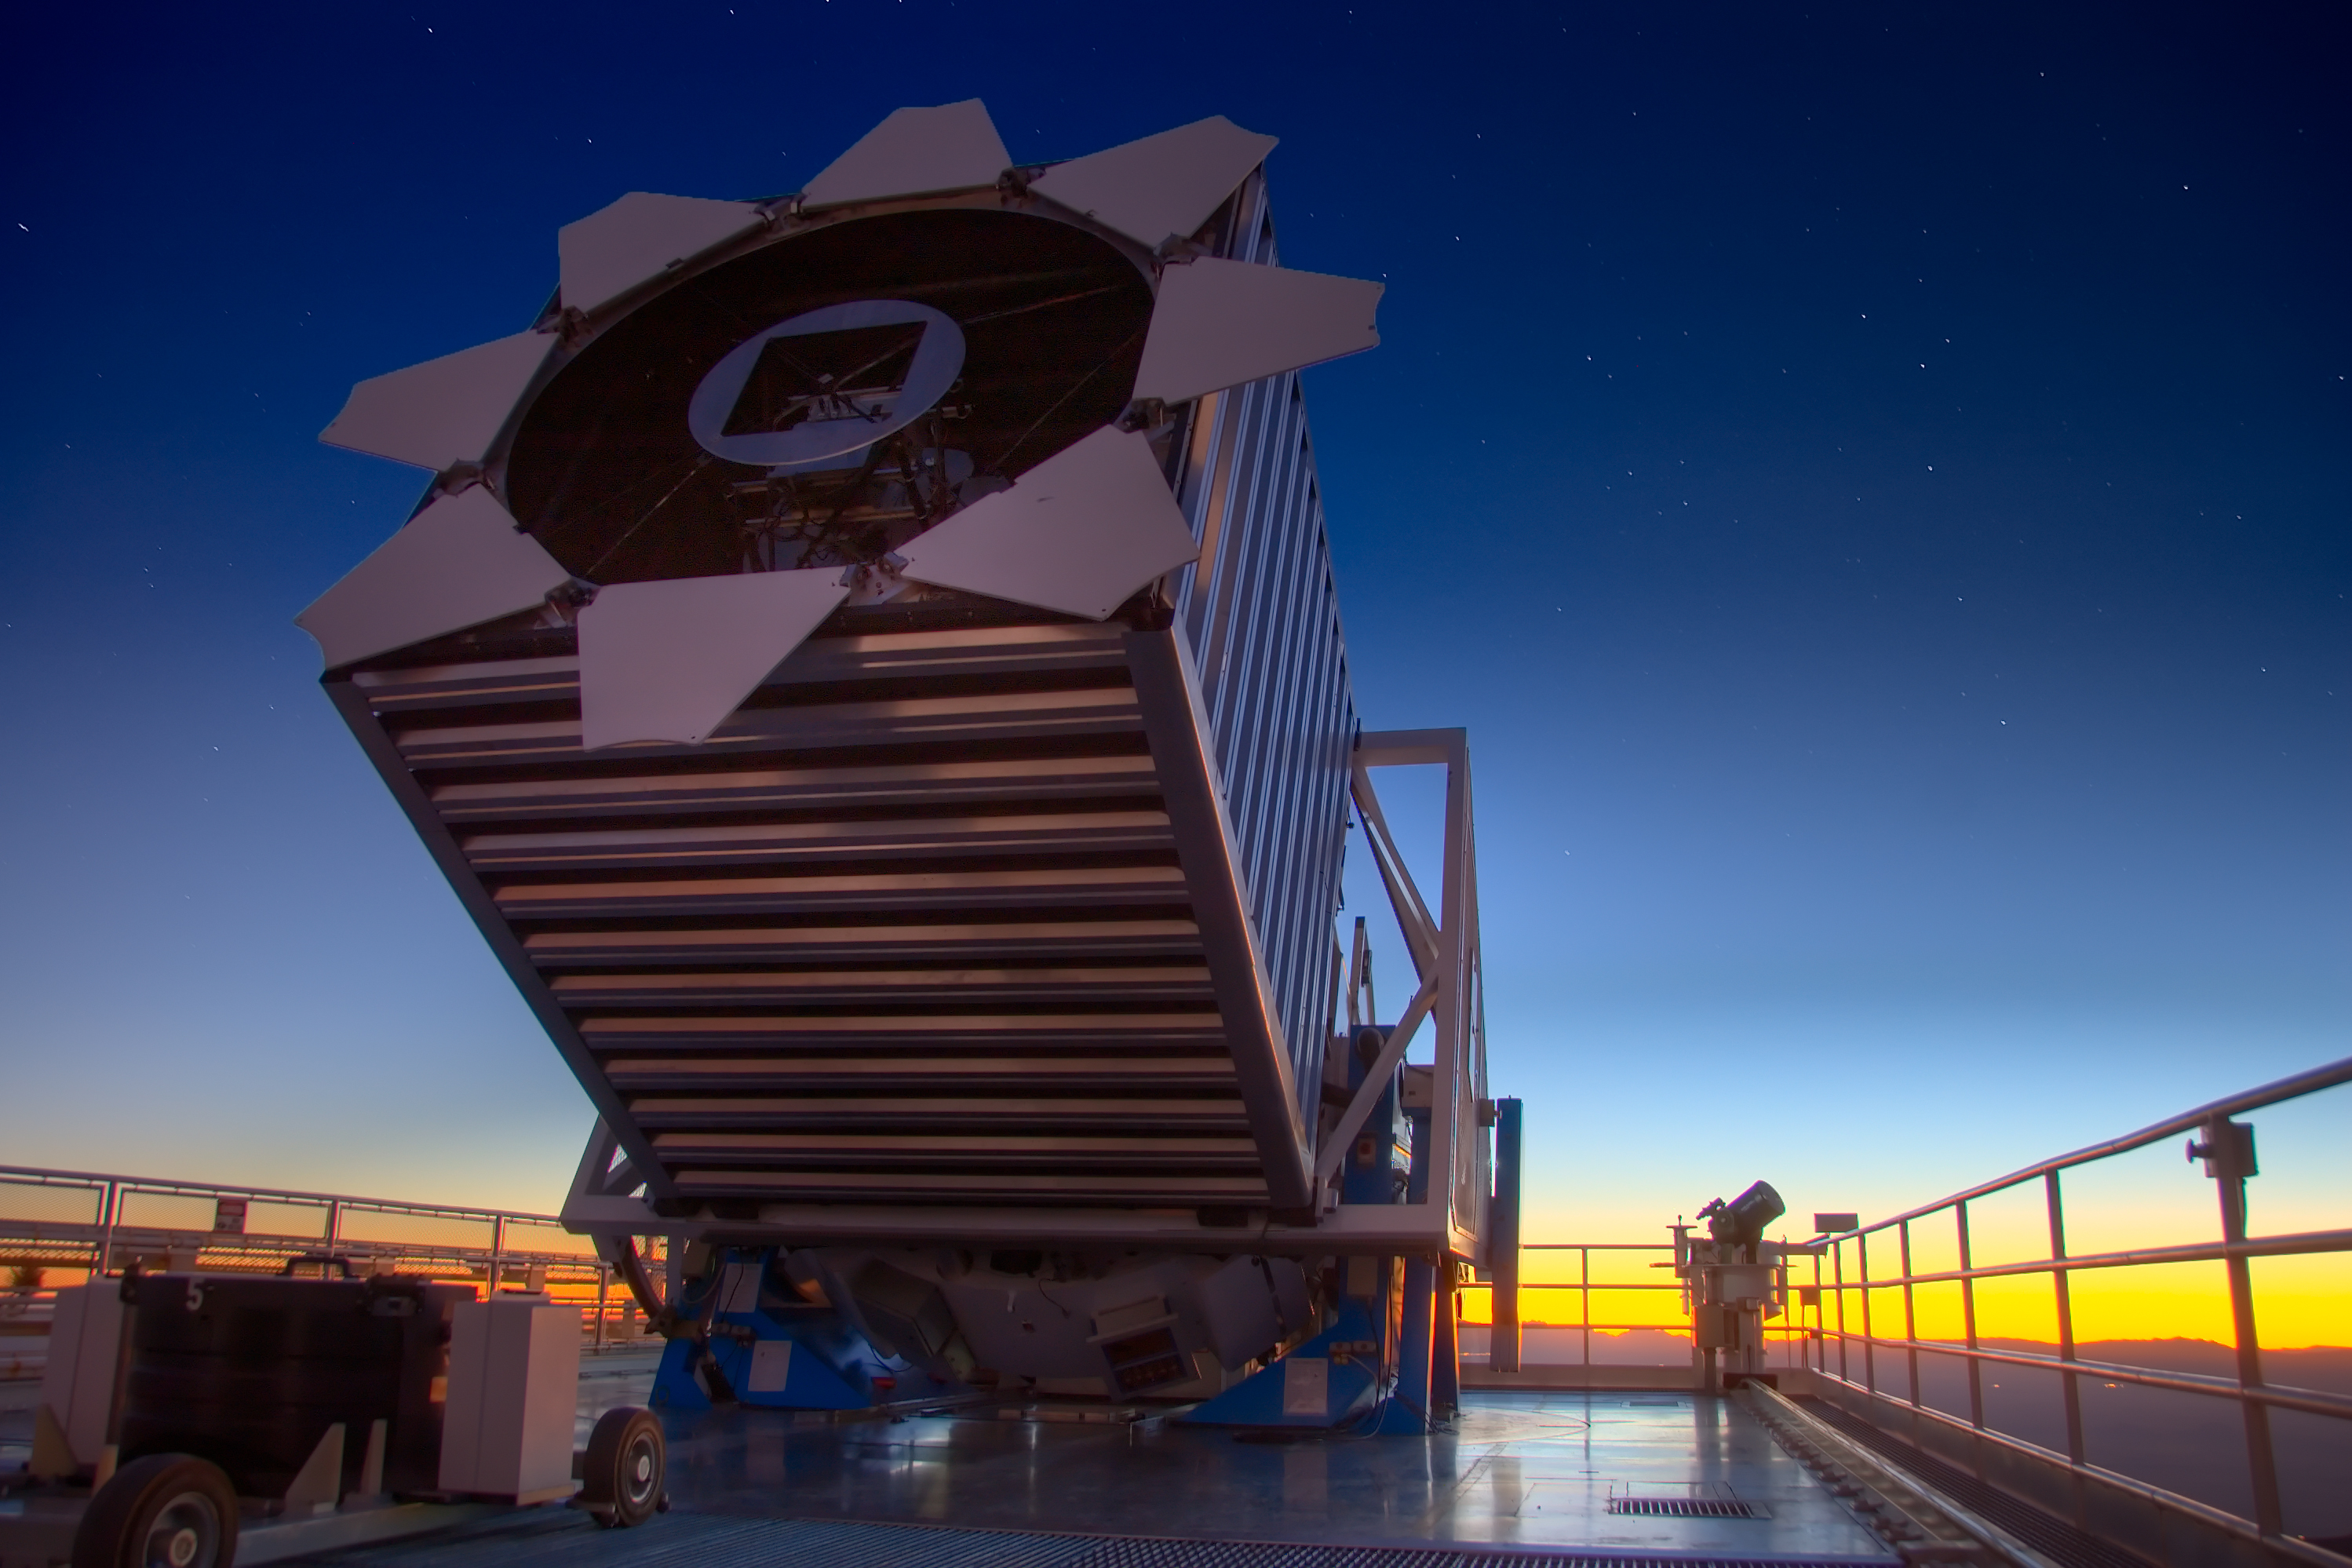

In [3]:
Image('data/sdss.jpg')

*Image from SDSS

## A few physics concepts for this section:

### 1) Blackbody Radiation:


#### All objects with a temperature above absolute zero (0 K, -273.15 degrees C) emit energy in the form of electromagnetic radiation.  A blackbody is a theoretical or model body which absorbs all radiation falling on it, reflecting or transmitting none. It is a hypothetical object which is a “perfect” absorber and a “perfect” emitter of radiation over all wavelengths.  The spectral distribution of the thermal energy radiated by a blackbody (i.e. the pattern of the intensity of the radiation over a range of wavelengths or frequencies) depends only on its temperature.

#### Based on this concept, astronomers use the distribution of measured colors in an object as a proxy for its temperature.

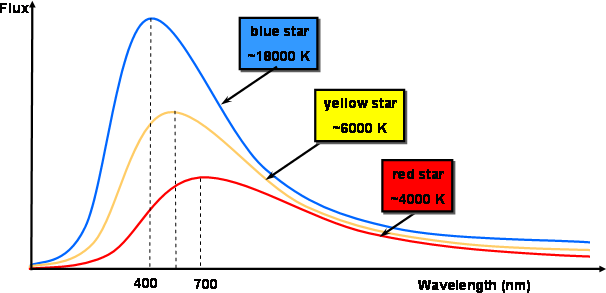

In [4]:
Image('data/blackbody_radn_curves.png') 

*Image & text from Swinburne University of Technology (http://astronomy.swin.edu.au/cosmos/B/Blackbody+Radiation)

### 2) Redshift:

#### Doppler effect can be described by the change in wavelength of light emitted by moving source.  A receding object emits light systematically moved towards larger wavelengths (to the red colors). 

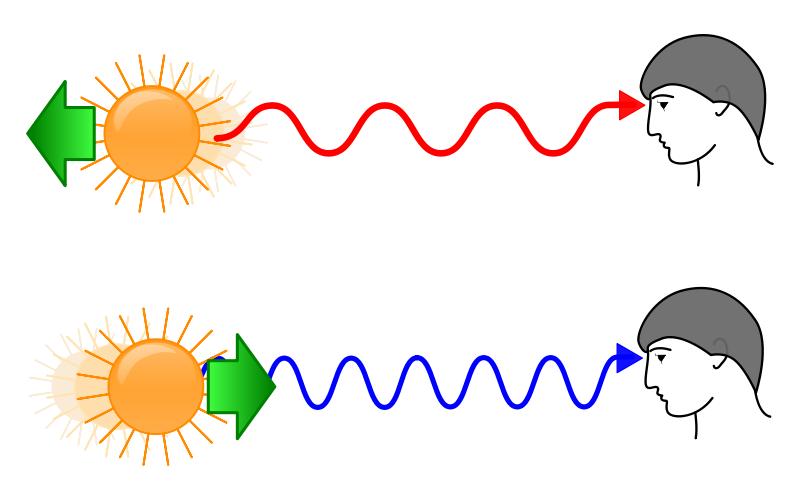

In [5]:
Image('data/redshift.png') 

*Image from Wikipedia.

#### Because the universe is expanding, objects further from us will recede faster (think of a balloon being inflated and how the relative velocity of two points further away on its surface will be larger than that of two nearby points). 

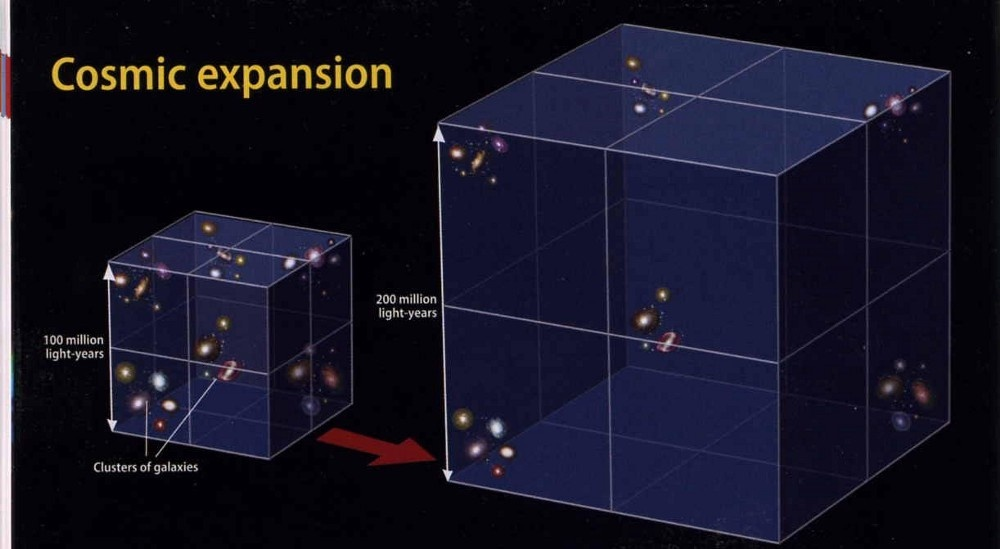

In [6]:
Image('data/expansion.jpeg') 

*Image from Quora (https://www.quora.com/If-the-age-of-universe-is-14-billion-years-how-are-we-able-to-receive-signals-from-galaxies-300-billion-light-years-away)

#### Combining these two concepts it is possible to estimate the distance of a body based on the energy distribution of its emission. 

### 3) Quasar:

#### Quasars are the most luminous objects in our Universe, some of them thousands of times brighter than our galaxy. They are located at the center of some galaxies and, while they are black holes, they emit light because they are accreating very hot plasma. 

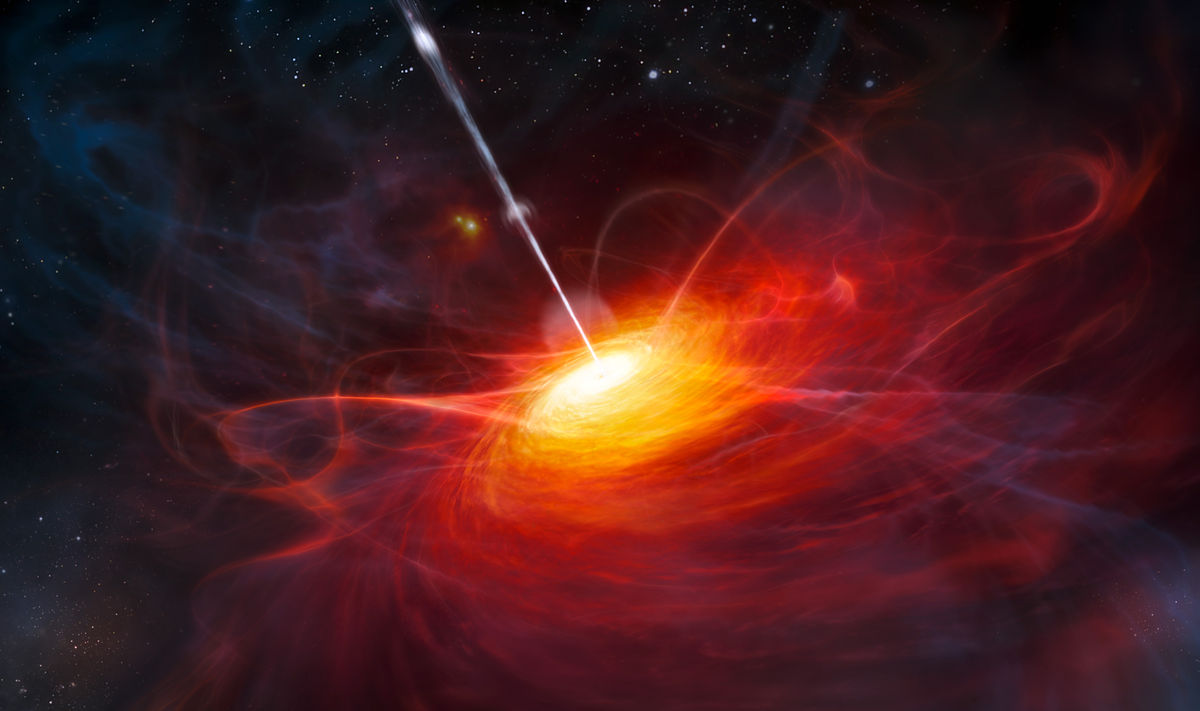

In [7]:
Image('data/quasar.jpeg')

*Image from Wikipedia.

# Data Preparation

## Load and investigate

In [8]:
sky = pd.read_csv('data/Skyserver_2.csv')
display(sky.head())
display(sky.describe())

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  146.603617 -0.191463  18.91808  17.66467  16.97991  16.55797   
1  1.237650e+18  147.830879 -0.175939  18.98907  17.97828  17.44428  17.25260   
2  1.237650e+18  147.842227 -0.000417  19.49610  18.58028  18.25762  18.13326   
3  1.237650e+18  147.863064 -0.168406  18.90579  17.75234  17.12903  16.70868   
4  1.237650e+18  150.441214 -0.154485  19.30410  17.58480  16.83829  16.47711   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  16.32081  756    301       3    206  2.995200e+17  GALAXY  0.121521    266   
1  17.09242  756    301       3    214  3.006650e+17  GALAXY  0.037041    267   
2  18.10417  756    301       3    214  4.310080e+18    STAR  0.000146   3828   
3  16.45255  756    301       3    214  3.006660e+17  GALAXY  0.125802    267   
4  16.16986  756    301       3    231  3.029540e+17  GALAXY  0.033204    269   

     mjd  fiberid  
0  51630      111  
1  51608      181  
2  55539      479  
3  51608      186  
4  51910      315

objid             ra            dec              u  \
count  2.000000e+05  200000.000000  200000.000000  200000.000000   
mean   1.237655e+18     178.686321      24.816779      18.638851   
std    4.979335e+12      77.097746      25.620110       0.831529   
min    1.237650e+18       0.002795     -11.252825      10.227170   
25%    1.237650e+18     137.232575       0.908004      18.212257   
50%    1.237650e+18     174.759439      15.012978      18.874230   
75%    1.237660e+18     222.176390      50.697999      19.275013   
max    1.237660e+18     359.996095      68.925750      19.599990   

                   g              r              i              z  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean       17.403152      16.874588      16.564581      16.303857   
std         0.978530       1.122199      22.427669      38.810382   
min         7.466997       8.449127   -9999.000000   -9999.000000   
25%        16.844877      16.186505      15.857110      15.617598   
50%        17.517360      16.891115      16.590470      16.413170   
75%        18.050670      17.564960      17.310303      17.193173   
max        19.982480      33.209920      32.349170      28.668700   

                 run     rerun         camcol          field     specobjid  \
count  200000.000000  200000.0  200000.000000  200000.000000  2.000000e+05   
mean     2080.103000     301.0       3.466770     203.906360  1.923518e+18   
std       767.613046       0.0       1.577047     152.119652  2.018399e+18   
min        94.000000     301.0       1.000000      11.000000  2.994900e+17   
25%      1458.000000     301.0       2.000000      86.000000  6.452250e+17   
50%      2137.000000     301.0       3.000000     165.000000  1.020120e+18   
75%      2728.000000     301.0       5.000000     279.000000  2.684260e+18   
max      3699.000000     301.0       6.000000     812.000000  1.008270e+19   

            redshift          plate            mjd        fiberid  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        0.169906    1708.345145   53149.708080     336.360185  
std         0.434031    1792.687266    1428.512516     204.980630  
min        -0.004136     266.000000   51578.000000       1.000000  
25%         0.000049     573.000000   52145.000000     165.000000  
50%         0.050072     906.000000   52427.000000     328.000000  
75%         0.098129    2384.000000   54271.000000     494.000000  
max         6.992002    8955.000000   57519.000000    1000.000000

In [9]:
sky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
objid        200000 non-null float64
ra           200000 non-null float64
dec          200000 non-null float64
u            200000 non-null float64
g            200000 non-null float64
r            200000 non-null float64
i            200000 non-null float64
z            200000 non-null float64
run          200000 non-null int64
rerun        200000 non-null int64
camcol       200000 non-null int64
field        200000 non-null int64
specobjid    200000 non-null float64
class        200000 non-null object
redshift     200000 non-null float64
plate        200000 non-null int64
mjd          200000 non-null int64
fiberid      200000 non-null int64
dtypes: float64(10), int64(7), object(1)
memory usage: 27.5+ MB


## Transform predictors

### Intensities to colors

The single-letter columns are the spectral energy in certain bands of wavelengths, so the differences between them tell us about color. Astronomers typically look at the following differences:

In [10]:
sky['u-g'] = sky['u'] - sky['g']
sky['g-r'] = sky['g'] - sky['r']
sky['r-i'] = sky['r'] - sky['i']
sky.head()

objid          ra       dec         u         g         r         i  \
0  1.237650e+18  146.603617 -0.191463  18.91808  17.66467  16.97991  16.55797   
1  1.237650e+18  147.830879 -0.175939  18.98907  17.97828  17.44428  17.25260   
2  1.237650e+18  147.842227 -0.000417  19.49610  18.58028  18.25762  18.13326   
3  1.237650e+18  147.863064 -0.168406  18.90579  17.75234  17.12903  16.70868   
4  1.237650e+18  150.441214 -0.154485  19.30410  17.58480  16.83829  16.47711   

          z  run  rerun   ...     field     specobjid   class  redshift  \
0  16.32081  756    301   ...       206  2.995200e+17  GALAXY  0.121521   
1  17.09242  756    301   ...       214  3.006650e+17  GALAXY  0.037041   
2  18.10417  756    301   ...       214  4.310080e+18    STAR  0.000146   
3  16.45255  756    301   ...       214  3.006660e+17  GALAXY  0.125802   
4  16.16986  756    301   ...       231  3.029540e+17  GALAXY  0.033204   

   plate    mjd  fiberid      u-g      g-r      r-i  
0    266  51630      111  1.25341  0.68476  0.42194  
1    267  51608      181  1.01079  0.53400  0.19168  
2   3828  55539      479  0.91582  0.32266  0.12436  
3    267  51608      186  1.15345  0.62331  0.42035  
4    269  51910      315  1.71930  0.74651  0.36118  

[5 rows x 21 columns]

In [11]:
#Double check
max(abs(
    (sky['u'] - sky['r']) -
    (sky['u-g'] + sky['g-r'])))

0.0

### Log-transform Redshift

Redshift makes much more sense in log-scale

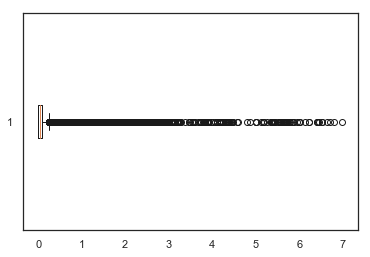

In [12]:
plt.boxplot(sky.redshift, vert=False);

In [13]:
# Negative redshift is physically impossible, so the np.maximum clips everything below 0 to 0.
# log of 0 is -inf, so shift up by a small constant
sky['log_redshift'] = np.log(np.maximum(sky.redshift, 0) + 1e-6)

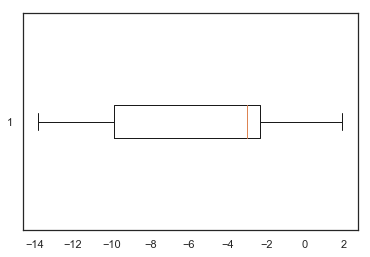

In [14]:
plt.boxplot(sky.log_redshift, vert=False);

## Make target numeric

In [15]:
sky['class'].value_counts()

GALAXY    106877
STAR       72303
QSO        20820
Name: class, dtype: int64

In [16]:
sky['class'].value_counts(normalize=True)

GALAXY    0.534385
STAR      0.361515
QSO       0.104100
Name: class, dtype: float64

**QSO is Quasars, representing about 10% of our data.**

We'll want to represent our target classes numerically.

**Exercise**: Could we use a dummy variable encoding for our 3 targets?

First we make a mapping from names to ids and back:

In [17]:
tgt_id2name = ['GALAXY', 'STAR', 'QSO']
tgt_name2id = {name: idx for idx, name in enumerate(tgt_id2name)}
print("Class 1 is", tgt_id2name[1])
print("Galaxy is class", tgt_name2id['GALAXY'])

Class 1 is STAR
Galaxy is class 0


Now we use that mapping to make a new numeric column.

In [18]:
sky['response'] = [tgt_name2id[cls] for cls in sky['class']]

## Separate data in train and test sets

In [19]:
data_train_raw, data_test_raw = train_test_split(sky, test_size=.3, random_state=2001)
len(data_train_raw), len(data_test_raw)

(140000, 60000)

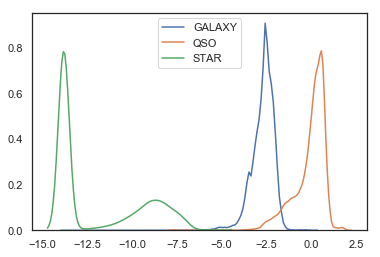

In [20]:
# This is the somewhat magic way:
data_train_raw.groupby('class').log_redshift.apply(lambda group: sns.kdeplot(group));

class
GALAXY    AxesSubplot(0.125,0.125;0.775x0.755)
QSO       AxesSubplot(0.125,0.125;0.775x0.755)
STAR      AxesSubplot(0.125,0.125;0.775x0.755)
Name: log_redshift, dtype: object

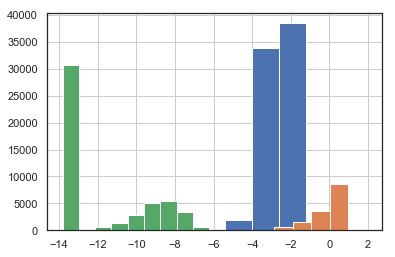

In [21]:
# Less magic, but less functional.
data_train_raw.groupby('class').log_redshift.hist()

## Scale data

In [22]:
def scale_df(df, means, stds):
    cols_to_scale = means.index
    df = df.copy()
    df[cols_to_scale] = (df[cols_to_scale] - means) / stds
    return df

cols_to_scale = ['u-g', 'g-r', 'r-i']
train_means = data_train_raw[cols_to_scale].mean(axis=0)
train_stds = data_train_raw[cols_to_scale].std(axis=0)

data_train = scale_df(data_train_raw, train_means, train_stds)
data_test = scale_df(data_test_raw, train_means, train_stds)

In [23]:
# Check results.
data_train[cols_to_scale].describe()

u-g           g-r           r-i
count  1.400000e+05  1.400000e+05  1.400000e+05
mean   1.179118e-14 -8.189271e-15 -1.978227e-16
std    1.000000e+00  1.000000e+00  1.000000e+00
min   -7.522239e+00 -4.355468e+01 -5.057106e-01
25%   -4.669444e-01 -5.770969e-01 -6.782710e-03
50%    2.125324e-02  3.755652e-02 -1.708342e-03
75%    6.553996e-01  6.943079e-01  2.576763e-03
max    9.175197e+00  1.125847e+01  3.741469e+02

## Visualize!

In [63]:
def scatter_stars(ax, df, columns, class_labels, class_colors, s=5,
                  xlim=[-4, 4], ylim=[-4, 4], **kw):
    for idx, (color, name) in enumerate(zip(class_colors, class_labels)):
        subset = df[df['class'] == name]
        ax.scatter(
            subset[columns[0]], subset[columns[1]],
            label=name,
            c=color, s=s, **kw)
    ax.set(xlabel=columns[0], ylabel=columns[1], xlim=xlim, ylim=ylim)
    ax.legend()

In [64]:
data_sample = data_train.sample(frac=.05)

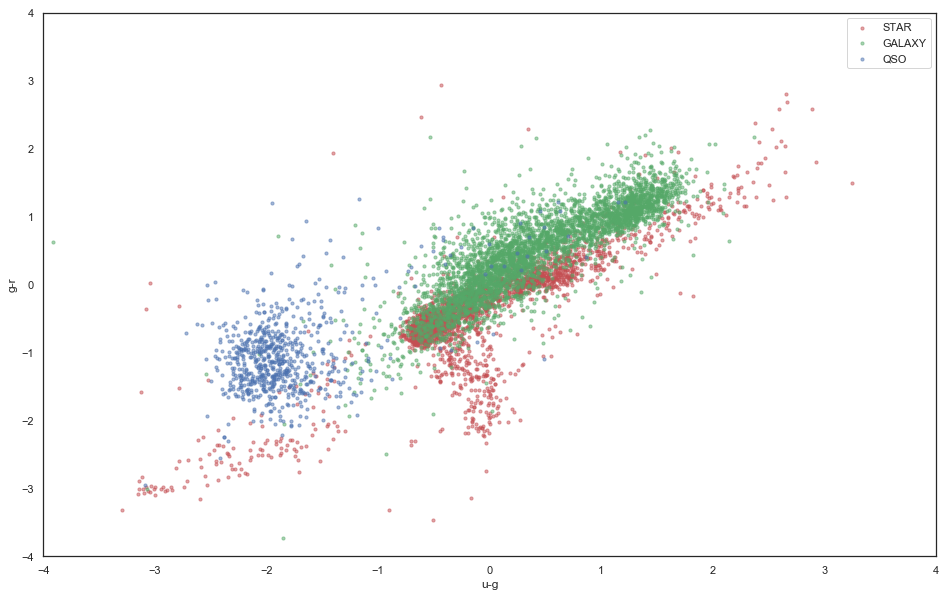

In [65]:
fig, ax = plt.subplots(1,1, figsize=(16,10))

scatter_stars(
    ax, data_sample,
    columns=['u-g', 'g-r'],
    # For overplotting demo, switch which of this line and the following is commented.
#     class_labels=['GALAXY', 'STAR', 'QSO'],
    class_labels=['STAR', 'GALAXY', 'QSO'],
    class_colors=['r', 'g', 'b'], s=10, alpha=.5)

Caution: the overplotting between Star and Galaxy is deceptive.

## Make classification task

In [25]:
predictors = ['u-g', 'g-r']

X_train = data_train.loc[:,predictors]
y_train = data_train.loc[:,'response']
X_test = data_test.loc[:,predictors]
y_test = data_test.loc[:,'response']

# Multi-class Classification Approaches

When we look at multiclass classifiers, the overall accuracy (mean of y_true == y_pred) is interesting, but doesn't show us if we're making more mistakes on one class or another. It especially down-weights mistakes on minority classes (here, quasars). Mistakes on minority classes may be far more important than their frequency suggests (especially if we're dealing with people), so let's also look at *confusion matrices*.

In [26]:
# Code credit: sklearn example
def plot_confusion_matrix(ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set(title=title, ylabel='True label', xlabel='Predicted label')


For example, if we always predict "star", we'd get a confusion matrix like:

Accuracy: 0.3645333333333333


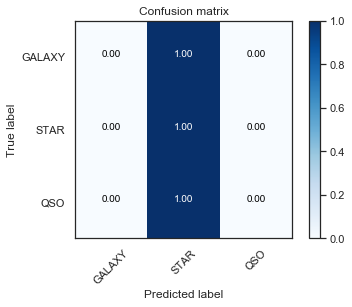

In [27]:
fig, ax = plt.subplots()
constant_predictions = np.full(len(y_test), 1)
cnf_matrix = confusion_matrix(y_test, constant_predictions)
plot_confusion_matrix(ax, cnf_matrix, classes=tgt_id2name, normalize=True)
print("Accuracy:", np.mean(constant_predictions == y_test))

Here's our routine from hw7 for plotting decision boundaries:

In [28]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    model = getattr(model, 'predict', model)
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

## Logistic Regression

**Estimation time** (it surprises me how fast this is... really?)

In [59]:
%time ovr = LogisticRegression(multi_class='ovr', solver='lbfgs').fit(X_train, y_train)

CPU times: user 810 ms, sys: 188 ms, total: 998 ms
Wall time: 267 ms


In [60]:
%timeit ovr = LogisticRegression(multi_class='ovr', solver='lbfgs').fit(X_train, y_train)

242 ms ± 9.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Inference time:**

In [62]:
ovr = LogisticRegression(multi_class='ovr', solver='lbfgs').fit(X_train, y_train)
%timeit predictions = ovr.predict(X_test)

1.88 ms ± 79.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### What's one-vs-rest doing?

One-vs-Rest fits 3 different classifiers: galaxy-vs-rest, star-vs-rest, and quasar-vs-rest. For example, the galaxy-vs-rest model is:

In [32]:
is_galaxy = (y_train == 0).astype(int)
galaxy_vs_rest = LogisticRegression(solver='saga').fit(X_train, is_galaxy)

Notice how the coefficients are exactly the same for this model...

In [33]:
galaxy_vs_rest.coef_, galaxy_vs_rest.intercept_

(array([[-0.31954908,  2.0910309 ]]), array([0.13686235]))

...and class 0 of the one-vs-rest model:

In [34]:
ovr.coef_[0], ovr.intercept_[0]

(array([-0.31955343,  2.09104437]), 0.1368552182578172)

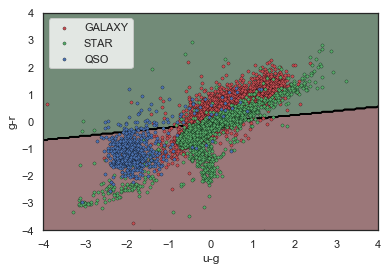

In [68]:
fig, ax = plt.subplots()
scatter_stars(
    ax, data_sample,
    columns=['u-g', 'g-r'],
    class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.25, s=10)

overlay_decision_boundary(ax, galaxy_vs_rest, colors=class_colors, desaturate=.3)

### CV for hyperparameter selection

The coefficients of Logistic Regression can be regularized by an L2 (magnitude) penalty. Let's use cross-validation to select a good penalty parameter.

In [35]:
%time lrm_ovr = LogisticRegressionCV(multi_class = 'ovr', cv=5).fit(X_train, y_train)

# We could also fit a Multinomial model, but that's beyond our scope here.
print('OvR Logistic Regression: accuracy on train={:.2%}, test={:.2%}'.format(
    lrm_ovr.score(X_train, y_train), lrm_ovr.score(X_test, y_test)))

CPU times: user 19.2 s, sys: 4.37 s, total: 23.6 s
Wall time: 6.21 s
OvR Logistic Regression: accuracy on train=76.54%, test=76.27%


Why might CPU times be greater than wall time? Hint: your CPU probably has multiple cores...

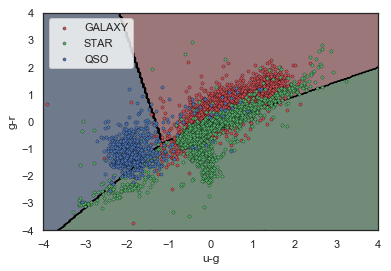

In [66]:
fig, ax = plt.subplots()
scatter_stars(
    ax, data_sample,
    columns=['u-g', 'g-r'],
    class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.25, s=10)

overlay_decision_boundary(ax, lrm_ovr, colors=class_colors, desaturate=.3)

## k-NN

kNN estimation time:

In [36]:
%time knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

CPU times: user 251 ms, sys: 64.1 ms, total: 315 ms
Wall time: 108 ms


Inference time:

In [37]:
%time knn_predictions = knn.predict(X_test)

CPU times: user 270 ms, sys: 13.8 ms, total: 284 ms
Wall time: 284 ms


Let's use a sklearn meta-estimator to find the best value of k. (On homework you should use `cross_val_score`; we're doing it a different way here so you can't just copy-paste code for one of the answers):

In [38]:
from sklearn.model_selection import GridSearchCV

In [69]:
kvals = [10, 50, 100]
t = time.time()
knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': kvals},
    cv=5).fit(X_train, y_train)
runtime_knn = time.time()-t

In [40]:
%timeit predictions = knn.predict(X_test)

1.26 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
print("Best k:", knn.best_params_['n_neighbors'])
print('kNN Test Score:', knn.score(X_test, y_test), ', runtime= ', runtime_knn)

Best k: 100
kNN Test Score: 0.8329 , runtime=  28.959781885147095


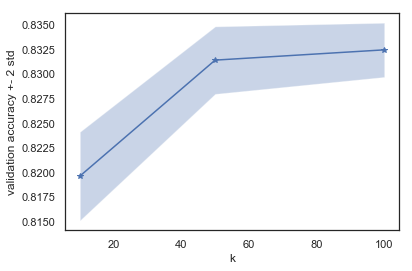

In [71]:
plt.plot(kvals, knn.cv_results_['mean_test_score'], '-*')
plt.fill_between(
    kvals,
    knn.cv_results_['mean_test_score'] - 2 * knn.cv_results_['std_test_score'],
    knn.cv_results_['mean_test_score'] + 2 * knn.cv_results_['std_test_score'],
    alpha=.3)
plt.xlabel('k')
plt.ylabel('validation accuracy +- 2 std');

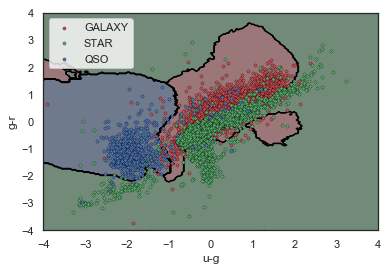

In [72]:
fig, ax = plt.subplots()
scatter_stars(
    ax, data_sample,
    columns=['u-g', 'g-r'],
    class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.25, s=10)
overlay_decision_boundary(ax, knn, colors=class_colors, desaturate=.3)

## LDA and QDA

LDA and QDA model each class as a Normal distribution. (Does that make sense for our data?)

To classify a sample, we use Bayes' rule:

$$P(y=k | X) = \frac{P(X | y=k) P(y=k)}{P(X)} = \frac{P(X | y=k) P(y = k)}{ \sum_{l} P(X | y=l) \cdot P(y=l)}$$

So the most likely class is:

$$\hat{y} = \arg\max_k P(y=k | X) = \arg\max_k P(X | y=k) P(y=k)$$

(see http://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-the-lda-and-qda-classifiers)

In [48]:
lda = LinearDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
qda = QuadraticDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])

t = time.time()
lda.fit(X_train, y_train)
fittime_lda = time.time()-t

t = time.time()
qda.fit(X_train, y_train)
fittime_qda = time.time()-t

t = time.time()
lda.predict(X_test)
infertime_lda = time.time() - t

t = time.time()
qda.predict(X_test)
infertime_qda = time.time() - t


print('LDA accuracy train={:.2%}, test: {:.2%}, fit time {:.2f}s, predict time {:.2f}s'.format(
    lda.score(X_train, y_train), lda.score(X_test, y_test), fittime_lda, infertime_lda))
print('QDA accuracy train={:.2%}, test: {:.2%}, fit time {:.2f}s, predict time {:.2f}s'.format(
    qda.score(X_train, y_train), qda.score(X_test, y_test), fittime_qda, infertime_qda))


LDA accuracy train=73.38%, test: 72.97%, fit time 0.07s, predict time 0.00s
QDA accuracy train=69.95%, test: 69.60%, fit time 0.02s, predict time 0.01s


Let's look at the model that LDA and QDA fit to the data. Do they make sense?

In [49]:
# Code credit: http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html
def plot_ellipse(ax, mean, cov, color):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = matplotlib.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

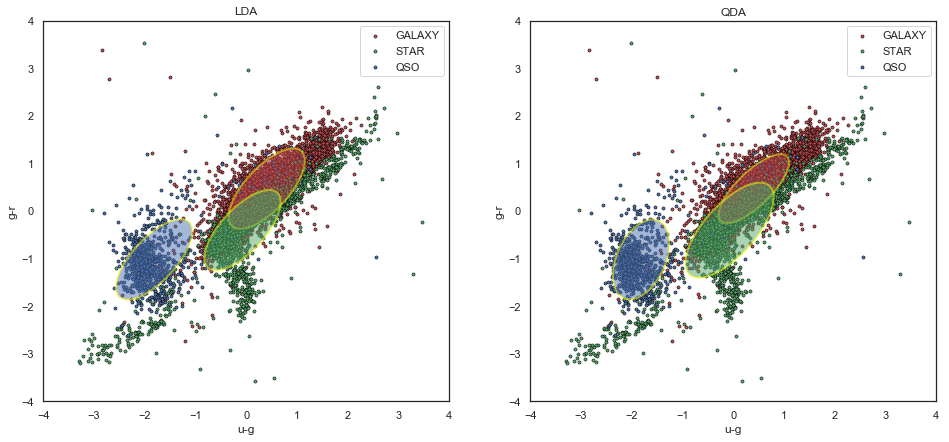

In [50]:
fitted_models = [lda, qda]
titles = ['LDA','QDA']
class_colors=['r', 'g', 'b']

f, axes = plt.subplots(1,2, figsize = (16,7))

for i, (model, ax, title) in enumerate(zip(fitted_models, axes, titles)):
    scatter_stars(
        ax, data_sample,
        columns=['u-g', 'g-r'],
        class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.5, s=10)
    for target, color in enumerate(class_colors):
        if isinstance(model, QuadraticDiscriminantAnalysis):
            # For QDA
            covariance = model.covariance_[target]
        else:
            # LDA
            covariance = model.covariance_
        plot_ellipse(ax, model.means_[target], covariance, color)
    ax.set_title(title)

What about those priors? Generally we estimate them from the data:

In [51]:
lda.priors_

array([0.5351    , 0.36022143, 0.10467857])

In [54]:
data_train.response.value_counts(normalize=True)

0    0.535100
1    0.360221
2    0.104679
Name: response, dtype: float64

... but we could use domain knowledge to set them.

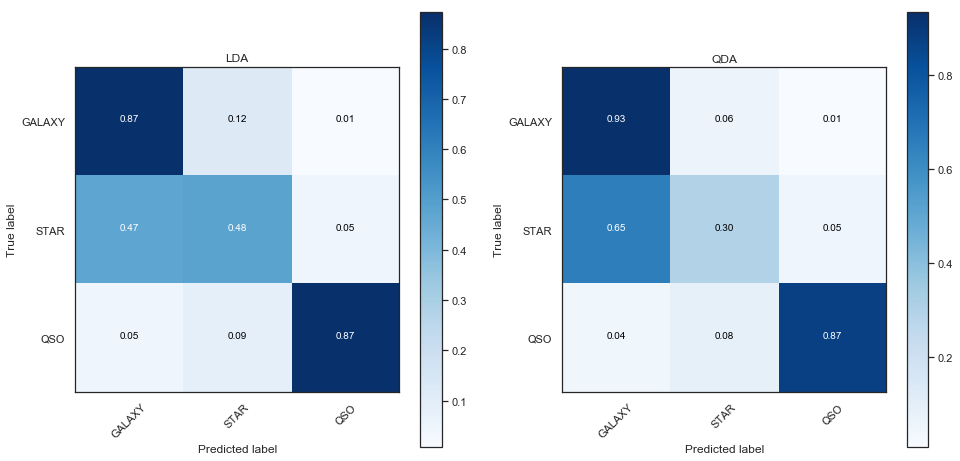

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))
for ax, title, model in zip(axs, 'LDA QDA'.split(), [lda, qda]):
    cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
#     cnf_matrix = confusion_matrix(np.full_like(y_test, 2), y_test)
    plot_confusion_matrix(ax, cnf_matrix, classes=tgt_id2name, normalize=True)
    ax.set_title(title)


In [73]:
# from sklearn 0.20
def balanced_accuracy_score(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    return score

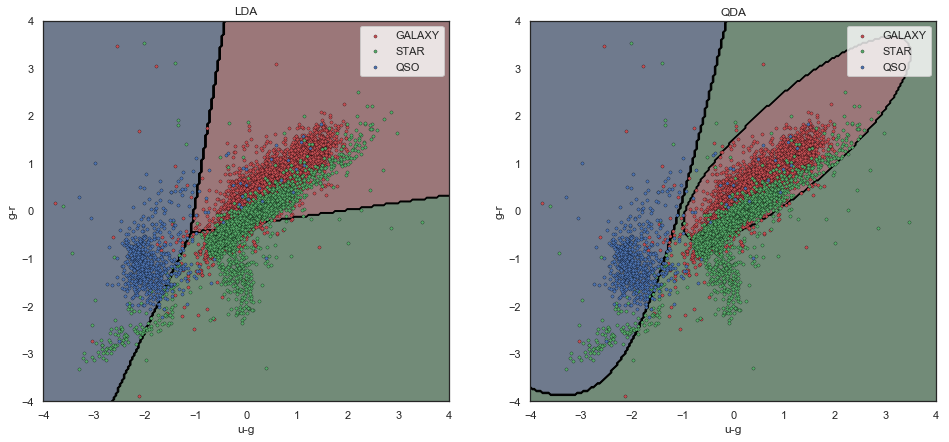

In [58]:
fitted_models = [lda, qda]
titles = ['LDA','QDA']
class_colors=['r', 'g', 'b']

f, axes = plt.subplots(1,2, figsize = (16,7))
data_sample = data_train.sample(frac=.05)

for i, (model, ax, title) in enumerate(zip(fitted_models, axes, titles)):
    scatter_stars(
        ax, data_sample,
        columns=['u-g', 'g-r'],
        class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.25, s=10)

    overlay_decision_boundary(ax, model, colors=class_colors, desaturate=.3)
    ax.set_title(title)
#     print("{}: accuracy on train={:.2%}, test={:.2%}".format(
#         title, balanced_accuracy_score(y_train, model.predict(X_train)),
#         balanced_accuracy_score(y_test, model.predict(X_test))))

### We are not doing great at separating stars from galaxies. What other information could help us distinguish these two? Here is where the domain knowledge becomes important. Stars can be observed only when they are close enough, while galaxies that we observe and look like stars (point source like) are much further away. Redshift is a measure of distance and is one of the columns in our dataset. Lets see what happens if we include it.

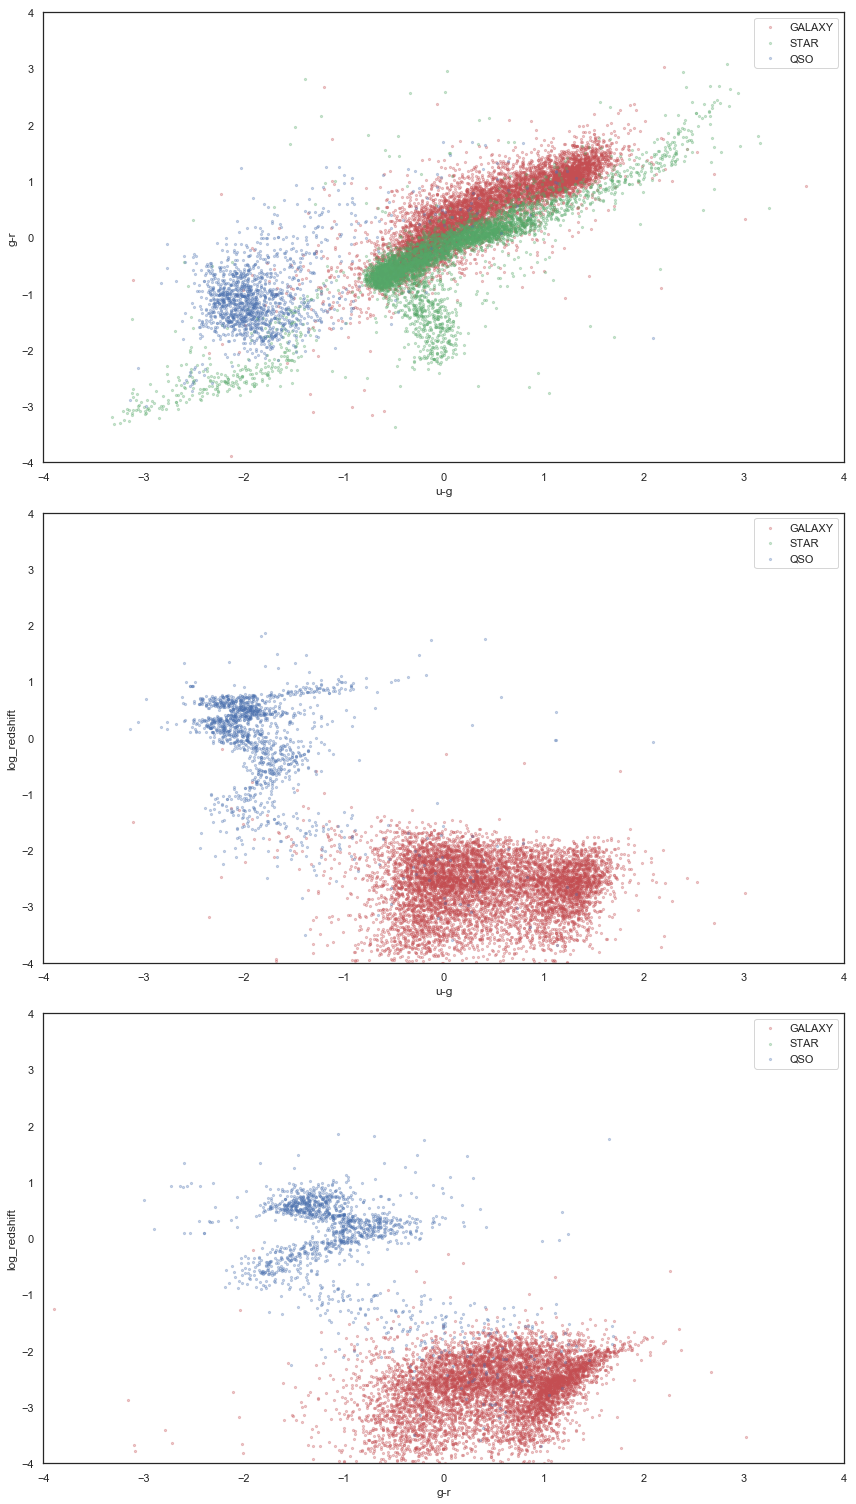

In [74]:
plot_columns = ['u-g', 'g-r' , 'log_redshift' ]
col_pairs = list(combinations(plot_columns, 2))
n = len(col_pairs)
fig, axes = plt.subplots(nrows=n, figsize=(12, 7 * n))

data_sample = data_train.sample(frac=.1)
for ax, columns in zip(axes, col_pairs):
    scatter_stars(ax, data_sample, columns, tgt_id2name, class_colors, alpha=.3)
    
fig.tight_layout()    

<div class="exercise"><b>Exercise</b></div>
Go back and change a color to 'redshift' in the predictors

In [75]:
predictors = ['u-g', 'log_redshift']

X_train = data_train.loc[:,predictors]
y_train = data_train.loc[:,'response']
X_test = data_test.loc[:,predictors]
y_test = data_test.loc[:,'response']

LDA: accuracy on train=97.66%, test=97.74%
QDA: accuracy on train=98.71%, test=98.71%


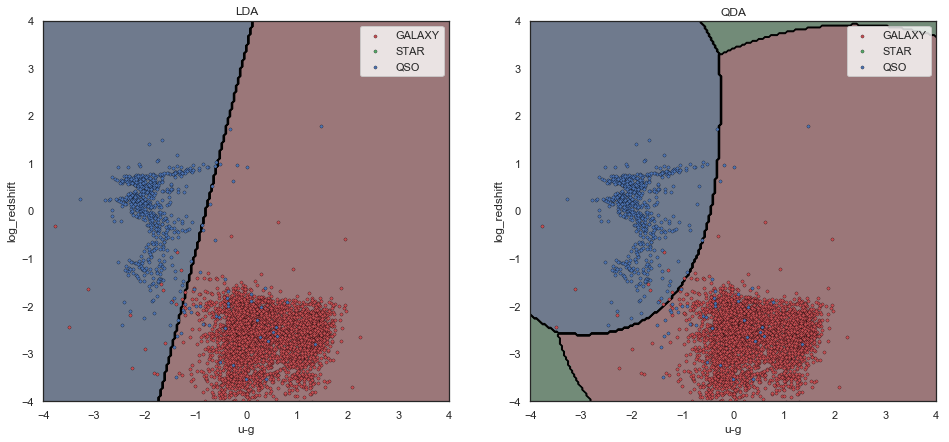

In [77]:
lda.fit(X_train, y_train)
qda.fit(X_train, y_train)
fitted_models = [lda, qda]
titles = ['LDA','QDA']
class_colors=['r', 'g', 'b']

f, axes = plt.subplots(1,2, figsize = (16,7))
data_sample = data_train.sample(frac=.05)

for i, (model, ax, title) in enumerate(zip(fitted_models, axes, titles)):
    scatter_stars(
        ax, data_sample,
        columns=predictors,
        class_labels=tgt_id2name, class_colors=class_colors, edgecolor='black', lw=.25, s=10)

    overlay_decision_boundary(ax, model, colors=class_colors, desaturate=.3)
    ax.set_title(title)
    print("{}: accuracy on train={:.2%}, test={:.2%}".format(
        title, model.score(X_train, y_train), model.score(X_test, y_test)))

### QDA now does better than LDA, why do you think that is?